# Pytorch Workflow

|Topic|Content|
|---|---|
|1. Getting data ready|Data can be almost anything but to get started we're going to create a simple straight line|
|2. Building a model|Here we'll create a model to learn pattterns in the data, we'll also choose a loss function, optimizer and build a training loop.|
|3. Fitting the model to data (training)|We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
|4. Making predictions and evaluating a model (inference)|Our model's found patterns in the data, let's compare its finding to the actual (testing) data.|
|5. Saving and loading a model|You may want to use your model elsewhere, or come back to it later, here we'll cover that.|
|6. Putting it all together|Let's take all of the above and combine it|

In [5]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.7.0.dev20250116+cu126'

## 1. Data (preparing and loading)
We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [7]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Split data into training and testing set

In [9]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [10]:
len(X)

50

Lets visualize the data

In [12]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

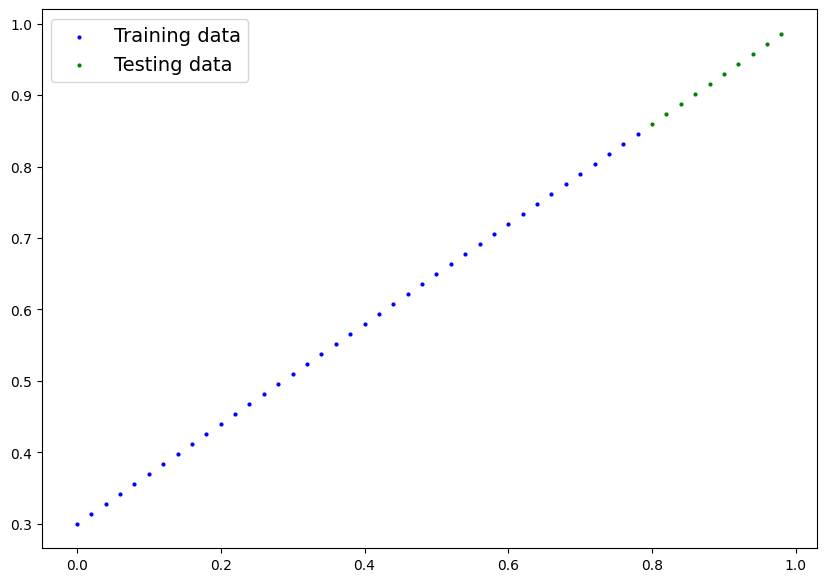

In [13]:
plot_predictions()

## 2. Build model
Now we've got some data, let's build a model to use the blue ddots to predict the green dots.

Let's replicated a standard linear regession model using pure PyTorch

In [15]:
# Create a Linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                    requires_grad=True) # <- can we update this value with gradient descents?))
    
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model, overwride forward in nn.module parent calss
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m * x + b)

## PyTorch model building essentials

|PyTorch module|What does it do?|
|--|--|
|torch.nn|contains all the building blocks for computational graphs (essentially a series of computations executed in a particular way).|
|torch.nn.Parameter|Stores tensors that can be used with nn.Modeule. If requires_grad=true gradients (used for updataing model parameters via gradient descent) are calculated automatically, this is often refereeed to as "autograd".|
|torch.nn.Module|The base class for all neural network modules, all the building blocks for neural networks are subclasses.|
|torch.optim|Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best chang to improve gradient descent and in turn reduce the loss).|
|def forward()|All nn.Module subclasses require a forward() method, this defines the computation taht will take place on the data passed to the particular nn.Module (eg., the linear regression formula above).|

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,

- `nn.Module` contains the larger building blocks (layers)
- `nn.Parameter` contains the smaller parameters like weights and biases (put these tother to make `nn.Module`(s))
- `forward()` tells tha larger blocks how to make calcualtions on inputs (tensors full of data) within `nn.Modeule`(s)
- `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

### Checking the comtents of a PyTorch model
Lets careate a model instance with the class we've made and check its parameters using `.parameters()`.

In [18]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()`.

In [20]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors?

This is because we initialized them above using `torch.randn()`.

Essentially we want to start from random parameters adn get the model to update them towards parameters that fit our data best (the hardcoded `weight` and `bias` values we set when creating our straight line data).

Because our Model starts witth random values, right now it'll have poor predictive power.

## Making predictions using `torch.inference_mode()`
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go throught the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.

In [23]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#    y_preds = model_0(X_test)

You probably noticed we use `torch.inference_mode()` as a context manager (that's what the `with torch.inference_model():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary fro training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

In [25]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


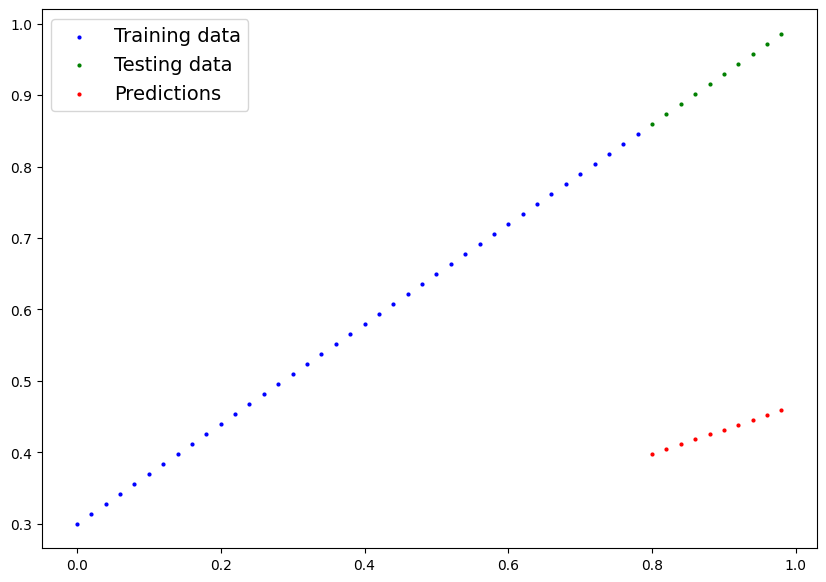

In [26]:
plot_predictions(predictions=y_preds)

In [27]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train model
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can aupdate its internal parameters (I alsoe refere to parameters as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents teh data.

### Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more thing to our recipe.

And that's a loss function as well as an optimizer.

The rolls of these are:

|Function|What does it do?|Where does it live in PyTorch?|Common values|
|--|--|--|--|
|Loss function| Measures how wrong your model's predictions (eg., `y_preds`) are compared to the truth labels (eg., `y_test`). Lower the better.|PyTorch has plenty of built-in loss functions in `torch.nn`.|Mean absolute error (MAE) for regression problems (`torch.nn.L1Loss()`). binary cross entropy for binary classification problems (`torch.nn.BCELoss()`).|
|Optimizer|Tells your model how to update its internal parameters to best lower the loss.|You can find various optimization functions implementations in `torch.optim`.|Stochastic gradient descent (`torch.optim.SGD()`). Adam optimizer (`torch.optim.Adam()`).|

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. and the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between 2 points (predictions and labels) and then takes the mean across all example.

And we'll use SGD, `torch.optim.SGD(params, lr)` where:
- `params` is the target model parameters you'd like to optimize (eg., the `weights` and `bias` values we randomly set before).
- `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optmizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The leaning rate is considered a hyperparameter (because it's set by a machine learning engineer). common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however these can be adjusted over time (this is called learning rate scheduling).


In [29]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to be optimized
                            lr=0.001) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=liss (might take a long time)) 

### Creating an optimization loop in PyTorch
The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing dta durning training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

### PyTorch training loop
For the training loop, we'll build the following steps:

|Number|Step name|What does it do?|Code example|
|--|--|--|--|
|1|Forward pass|The model goes through all the training data once, performing its `forward()` function calculations.|`model(x_train)`|
|2|Calculate the loss|The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.|`loss = loss_fn(y_pred, y_train)`|
|3|Zero gradients|The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.|`optimizer.zero_grad()`|
|4|Perform backpropagation on the loss|Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropatation, hence "backwards".|`loss.backward()`|
|5|Update the optimizer (gradient descent)|Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.|`optimizer.step()`|

### PyTorch testing loop
As for the testing loop (evaluating our model), the typical steps include:

|Number|Step name|What does it do?|Code example|
|--|--|--|--|
|1|Forward pass|The model goes through all the testing data once, performing its `forward()` function calculations.|`model(x_test)`|
|2|Calculate the loss|The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.|`Loss = loss_fn(y_pred, y_test)`|
|3|Calculate evaluation metrics (optional)|Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.|Custom functions|

Train our model for 100 epochs (forward pases throught the data) and we'll evaluate it every 10 epochs.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count =[]

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state for a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)

        # 2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening\
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

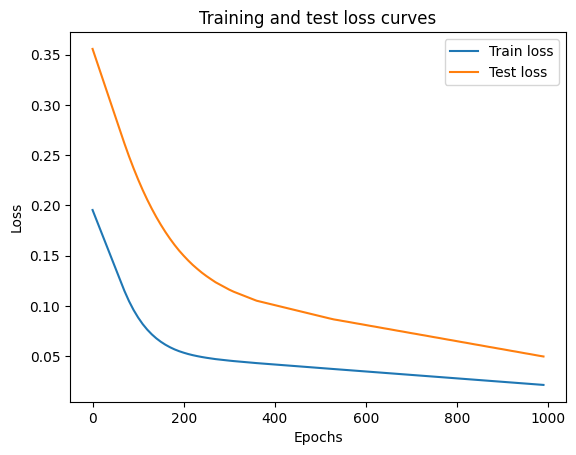

In [85]:
# plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### 5. saving and loading a PyTorch model

|PyTorch method| What does it do?|
|--|--|
|`torch.save`|Saves a serialized object to dis using Python's `pickle` utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.|
|`torch.load`|Uses `pickle`'s unpickling features to desearialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).|
|`torch.nn.Module.load_state_dict`|Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object.|

#### Saving a PyTorch model's `state_dict()`
The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`

Let's see how we can do that in a few steps:

1. We'll create a dictionary for saving models called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

In [98]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Crete model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the stae_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [103]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 yi yi 1680 Jan 16 20:12 models/01_pytorch_workflow_model_0.pth


#### Loading a saved PyTorch model's `state_dict()`
We can now load it using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `sate_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

Saving the entire model rather than just the state_dict() is more intuitive, however, to quote the PyTorch documentation (italics mine):

The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

Because of this, your code can break in various ways when used in other projects or after refactors.

Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module`` and will hence have the in-built method `load_state_dict()`.

In [109]:
# Instantiate a new instance of our model this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Performing inference with PyTorch models.

PyTorch inference rules:
1. Set the model in evaluation model (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_model(): ...`).
3. All predictions should be made with objects on the same device (eg., data and model on GPU only or data and model on CPU only).

In [115]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions wtih the loaded model, let's see if they're the same as the previous predictions.

In [147]:
# Compare previous model predictions with loaded model predictions (these should be the same)
all(y_preds == loaded_model_preds) or plot_predictions(test_data=X_test, test_labels=y_test, predictions=loaded_model_preds)

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

Are predictions equal? tensor(False)
Differences found:
Indices of differences: tensor([[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 0],
        [6, 0],
        [7, 0],
        [8, 0],
        [9, 0]])
Values in y_preds at differing indices: tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])
Values in loaded_model_preds at differing indices: tensor([0.8205, 0.8325, 0.8444, 0.8563, 0.8682, 0.8802, 0.8921, 0.9040, 0.9159,
        0.9279])


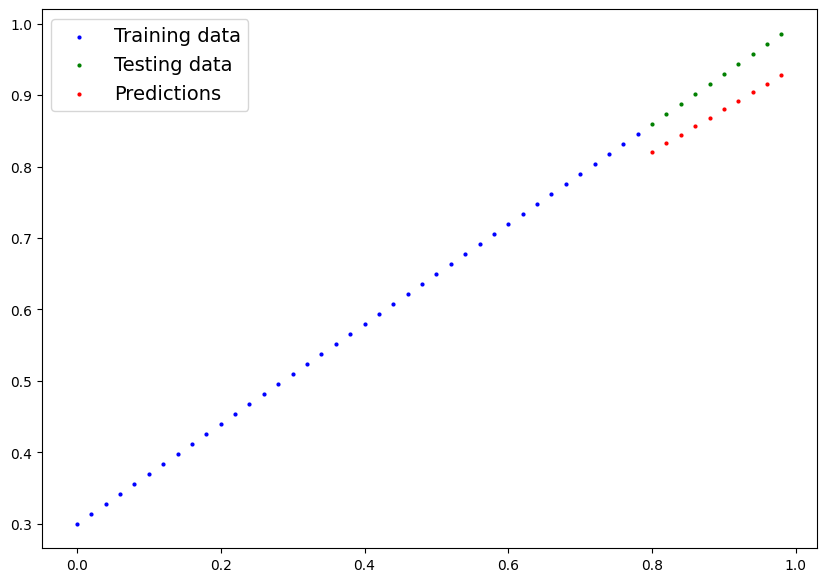

In [157]:
all(y_preds == loaded_model_preds) or plot_predictions(test_data=X_test, test_labels=y_test, predictions=loaded_model_preds)
torch.allclose(y_preds, loaded_model_preds)
are_predictions_equal = torch.all(torch.eq(y_preds, loaded_model_preds))
print("Are predictions equal?", are_predictions_equal)

if not are_predictions_equal:
    print("Differences found:")
    differences = y_preds != loaded_model_preds
    print("Indices of differences:", torch.nonzero(differences))
    print("Values in y_preds at differing indices:", y_preds[differences])
    print("Values in loaded_model_preds at differing indices:", loaded_model_preds[differences])